In [17]:
# Install and download dataset
#!pip install -q kagglehub
import kagglehub
dataset_path = kagglehub.dataset_download("indk214/brain-tumor-dataset-segmentation-and-classification")

# Import libraries
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import remove_small_objects



In [18]:
# Collect image-mask pairs
image_paths = []
mask_paths = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".png") and not file.endswith("_mask.png"):
            img_path = os.path.join(root, file)
            mask_path = img_path.replace(".png", "_mask.png")
            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)

print("Total image-mask pairs:", len(image_paths))



Total image-mask pairs: 2192


In [19]:
# Set image size
IMG_SIZE = 256

# Define metrics
def dice(y_true, y_pred):
    inter = np.sum(y_true * y_pred)
    return 2 * inter / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

def jaccard(y_true, y_pred):
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return inter / (union + 1e-8)




In [20]:
# Hyperparameter search for Sauvola
param_sets = [(9,0.1),(15,0.2),(25,0.2),(25,0.3),(35,0.3),(51,0.5)]
SUBSET = 400

best_dice = 0
best_params = None

for window, k in param_sets:
    dice_scores = []
    for img_path, mask_path in zip(image_paths[:SUBSET], mask_paths[:SUBSET]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.uint8)

        img = cv2.GaussianBlur(img, (5,5), 0)

        t = threshold_sauvola(img, window_size=window, k=k)
        pred = (img > t).astype(np.uint8)
        pred = remove_small_objects(pred.astype(bool), min_size=100).astype(np.uint8)

        dice_scores.append(dice(mask, pred))

    mean_d = np.mean(dice_scores)
    print("Window:", window, "k:", k, "Dice:", mean_d)

    if mean_d > best_dice:
        best_dice = mean_d
        best_params = (window, k)

print("Best Sauvola Parameters:", best_params)



Window: 9 k: 0.1 Dice: 0.0366659649769225
Window: 15 k: 0.2 Dice: 0.03801691318343452
Window: 25 k: 0.2 Dice: 0.039918640849706775
Window: 25 k: 0.3 Dice: 0.04039879018206619
Window: 35 k: 0.3 Dice: 0.04306989905767715
Window: 51 k: 0.5 Dice: 0.04660908879329312
Best Sauvola Parameters: (51, 0.5)


In [21]:
# Final evaluation
dice_otsu = []
dice_sauvola = []
jacc_otsu = []
jacc_sauvola = []

for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.uint8)

    img = cv2.GaussianBlur(img, (5,5), 0)

    t_otsu = threshold_otsu(img)
    otsu_mask = (img > t_otsu).astype(np.uint8)
    otsu_mask = remove_small_objects(otsu_mask.astype(bool), min_size=100).astype(np.uint8)

    window, k = best_params
    t_sauvola = threshold_sauvola(img, window_size=window, k=k)
    sauvola_mask = (img > t_sauvola).astype(np.uint8)
    sauvola_mask = remove_small_objects(sauvola_mask.astype(bool), min_size=100).astype(np.uint8)

    dice_otsu.append(dice(mask, otsu_mask))
    dice_sauvola.append(dice(mask, sauvola_mask))

    jacc_otsu.append(jaccard(mask, otsu_mask))
    jacc_sauvola.append(jaccard(mask, sauvola_mask))


100%|██████████| 2192/2192 [00:29<00:00, 74.12it/s]



Otsu Mean Dice: 0.061958582337457206
Otsu Mean Jaccard: 0.03272572440819738
Sauvola Mean Dice: 0.03929080222378406
Sauvola Mean Jaccard: 0.020288679818579302


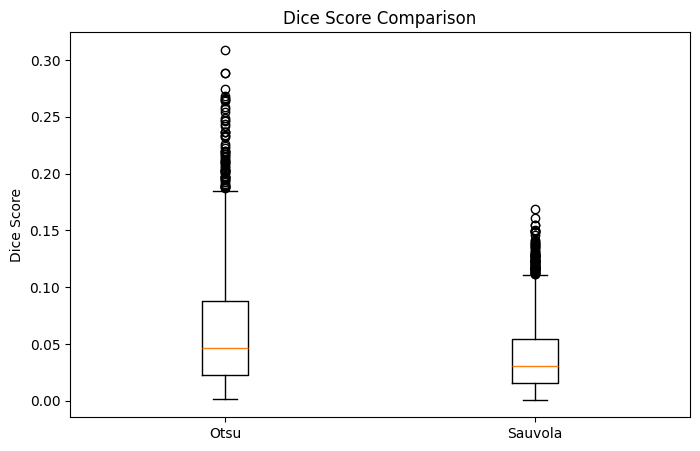

In [22]:

print("\nOtsu Mean Dice:", np.mean(dice_otsu))
print("Otsu Mean Jaccard:", np.mean(jacc_otsu))
print("Sauvola Mean Dice:", np.mean(dice_sauvola))
print("Sauvola Mean Jaccard:", np.mean(jacc_sauvola))

# Plot comparison
plt.figure(figsize=(8,5))
plt.boxplot([dice_otsu, dice_sauvola], tick_labels=["Otsu","Sauvola"])
plt.ylabel("Dice Score")
plt.title("Dice Score Comparison")
plt.show()

# Conclusion
In this experiment, Otsu thresholding consistently outperformed Sauvola adaptive thresholding on the given brain tumor dataset. Despite tuning the hyperparameters, adaptive thresholding did not significantly improve segmentation accuracy. This suggests that, for this dataset, global thresholding is more effective than local adaptive methods for tumor segmentation.
